In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
from tqdm import tqdm
%matplotlib inline

In [66]:
import chardet
with open("Corona_NLP_train.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}

In [67]:
train_df = pd.read_csv("Corona_NLP_train.csv", encoding = "latin1")
test_df = pd.read_csv("Corona_NLP_test.csv", encoding = "latin1")

In [68]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [69]:
print("Number of rows: {}\nNumber of columns: {}".format(train_df.shape[0], train_df.shape[1]))

Number of rows: 41157
Number of columns: 6


In [70]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [71]:
train_df.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [72]:
x = (train_df.isnull().sum()["Location"]/train_df.shape[0])*100
print("Perc. of null values in Location column: {}".format(x))

Perc. of null values in Location column: 20.87129771363316


In [73]:
null_df = train_df[train_df["Location"].isnull()] 

In [74]:
null_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
14,3813,48765,NaN,16-03-2020,ADARA Releases COVID-19 Resource Center for Tr...,Positive
22,3821,48773,NaN,16-03-2020,We have AMAZING CHEAP DEALS! FOR THE #COVID201...,Extremely Positive
23,3822,48774,NaN,16-03-2020,We have AMAZING CHEAP DEALS! FOR THE #COVID201...,Extremely Positive


In [75]:
non_null_df = train_df[~train_df["Location"].isnull()] 

In [76]:
user_screen_mapping = dict(non_null_df[["UserName", "ScreenName"]].values)

In [77]:
len(user_screen_mapping)

32567

In [78]:
non_null_df.shape

(32567, 6)

In [79]:
non_null_df[["UserName", "ScreenName"]].nunique()

UserName      32567
ScreenName    32567
dtype: int64

UserName and ScreenName has one-to-one relationship

In [80]:
user_location_mapping = dict(non_null_df[["UserName", "Location"]].values)

In [81]:
non_null_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive
...,...,...,...,...,...,...
41147,44946,89898,"Brooklyn, NY",14-04-2020,YÂall really shitting that much more at home?...,Negative
41149,44948,89900,"Toronto, Ontario",14-04-2020,Still shocked by the number of #Toronto superm...,Negative
41150,44949,89901,OHIO,14-04-2020,I never that weÂd be in a situation &amp; wor...,Positive
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral


In [82]:
user_location_mapping[3801]

'Vagabonds'

In [83]:
users_with_location = set(non_null_df['UserName'].values)

In [84]:
users_without_location = set(null_df['UserName'].values)

In [85]:
users_without_location.intersection(users_with_location)

set()

In [86]:
s1 = {1,2,3,4}
s2 = {5,6,7,8}
s1.intersection(s2)

set()

Location column, though it may be useful in classification, it has 20 perc. missing values and rest of the values are unclean so dropping it for now.

In [89]:
train_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [90]:
to_keep = ["OriginalTweet", "Sentiment"]
train_df = train_df[to_keep]
test_df = test_df[to_keep]

In [179]:
def preprocess(df):
    """This function accepts a pandas dataframe containing a column of OriginalTweets and output the processed dataframe"""
    
    #Convert to lower
    df["OriginatTweet"] = df["OriginalTweet"].apply(str.lower)
    #extract hasgtags and tags, join them by empty space and store them
    def extract_hashtags(s):
        hashtags = re.findall(r"#(\w+)", s)
        ats = re.findall(r"@(\w+)", s)
        return hashtags, ats
    
    tweets = df["OriginalTweet"].values
    hashtags = []
    tags = []
    for tweet in tqdm(tweets):
        h,a = extract_hashtags(tweet)
        hashtags.append(" ".join(h))
        tags.append(" ".join(a))
    
    df["hashtags"] = hashtags
    df["tags"] = tags
    
    # https://stackoverflow.com/a/47091490/4084039
    import re

    def decontracted(phrase):
        # specific
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)

        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        return phrase
    
    # Combining all the above stundents 
    from tqdm import tqdm
    def preprocess_text(text_data):
        preprocessed_text = []
        # tqdm is for printing the status bar
        for sentence in tqdm(text_data):
            if type(sentence) != str:
                sent = ' '
            else:
                sent = re.sub(r'http\S+', '', sentence) #remove url
                sent = decontracted(sent) #decontract
                sent = sent.replace('\\r', ' ') 
                sent = sent.replace('\\n', ' ')
                sent = sent.replace('\\"', ' ')
                sent = re.sub('[^A-Za-z0-9]+', ' ', sent) #remove anythong non-alphanumeric

            # https://gist.github.com/sebleier/554280
            sent = ' '.join(e for e in sent.split())
            preprocessed_text.append(sent.lower().strip())
        return preprocessed_text
    
    preprocessed_tweets = preprocess_text(tweets)
    
    df["preprocessed tweets"] = preprocessed_tweets
    return df
    

    

In [99]:
train_df["OriginalTweet"] = train_df["OriginalTweet"].apply(str.lower)

C:\Users\anike\.conda\envs\tf_test\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [104]:
train_df["Sentiment"].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [106]:
target_proportions = train_df.groupby("Sentiment").count()

Precision, recall, f1 score

In [107]:
target_proportions

,OriginalTweet
Sentiment,
Extremely Negative,5481
Extremely Positive,6624
Negative,9917
Neutral,7713
Positive,11422


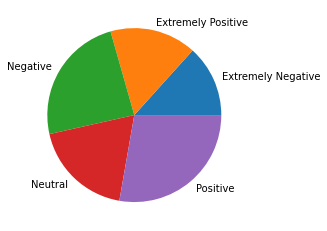

In [109]:
data = target_proportions["OriginalTweet"].values
keys = target_proportions.index 
plt.pie(data, labels = keys)
plt.show()

In [113]:
idxs = np.random.randint(0, 41156, 10)

In [116]:
for sent in train_df["OriginalTweet"][idxs].values:
    print(sent)
    print("*"*100)

greek supermarkets have cashed in over 615 million euros in just four weeks as fear of what is yet to come led to consumers panic buying large quantities of disinfectants and food with a long shelf life
****************************************************************************************************





@ctvatlantic
****************************************************************************************************
this surge in renewable generation worked with low demand, following the closure of factories and workplaces due to the lockdown caused by the covid-19 pandemic. https://t.co/9cyfwqwtqv
****************************************************************************************************


https://t.co/nue9zffujy via @phocuswire #coronavirus #coronavirusupdates #covid19 #corona #coronaviruspandemic
****************************************************************************************************
the latest consumer warning centers on two fake medical supply companies tha

1. Remove web addresses
2. Extract hashtags and @ tags
3. decontract
4. Remove punctuation
5. Remove emojis
6. Remove new lines, tabs, extra spaces

In [174]:
s = "there is no delivery date at ralph's/instacart at this time, like, none whatsoever, so... i'm trying to figure out how to get food at home to help my mom out at this moment.wondering if panic buying or just rush of internet orders because covid-19. https://t.co/ibrsqydxka"

In [175]:
s

"there is no delivery date at ralph's/instacart at this time, like, none whatsoever, so... i'm trying to figure out how to get food at home to help my mom out at this moment.wondering if panic buying or just rush of internet orders because covid-19. https://t.co/ibrsqydxka"

"there is no delivery date at ralph's/instacart at this time, like, none whatsoever, so... i'm trying to figure out how to get food at home to help my mom out at this moment.wondering if panic buying or just rush of internet orders because covid-19. "

In [122]:
# ony keeps alpha numeric
re.sub(r'[^A-Za-z0-9 ]+', '', s)

'there is no delivery date at ralphsinstacart at this time like none whatsoever so im trying to figure out how to get food at home to help my mom out at this momentwondering if panic buying or just rush of internet orders because covid19 httpstcoibrsqydxka'

In [130]:
s = "does it count if @realdonaldtrump calls you an âhonorableâ person? #trumpvirus #stophoarding #coronavirus"

In [131]:
def extract_hashtags(s):
    hashtags = re.findall(r"#(\w+)", s)
    ats = re.findall(r"@(\w+)", s)
    return hashtags, ats

In [132]:
s

'does it count if @realdonaldtrump calls you an â\x91honorableâ\x92 person? #trumpvirus #stophoarding #coronavirus'

In [133]:
h,a = extract_hashtags(s)

In [136]:
",".join(h)

'trumpvirus,stophoarding,coronavirus'

In [138]:
",".join(a)

'realdonaldtrump'

In [141]:
tweets = train_df["OriginalTweet"].values
hashtags = []
tags = []
for tweet in tqdm(tweets):
    h,a = extract_hashtags(tweet)
    hashtags.append(" ".join(h))
    tags.append(" ".join(a))
        

100%|████████████████████████████████████████████████████████████████████████| 41157/41157 [00:00<00:00, 380686.53it/s]


In [162]:
train_df["hashtags"] = hashtags
train_df["tags"] = tags

C:\Users\anike\.conda\envs\tf_test\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\anike\.conda\envs\tf_test\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [169]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [170]:
# Combining all the above stundents 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentence in tqdm(text_data):
        if type(sentence) != str:
            sent = ' '
        else:
            sent = re.sub(r'http\S+', '', sentence) #remove url
            sent = decontracted(sent) #decontract
            sent = sent.replace('\\r', ' ') 
            sent = sent.replace('\\n', ' ')
            sent = sent.replace('\\"', ' ')
            sent = re.sub('[^A-Za-z0-9]+', ' ', sent) #remove anythong non-alphanumeric
            
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split())
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [172]:
preprocessed_tweets = preprocess_text(tweets)

100%|█████████████████████████████████████████████████████████████████████████| 41157/41157 [00:00<00:00, 44189.72it/s]


In [177]:
train_df["preprocessed tweets"] = preprocessed_tweets

C:\Users\anike\.conda\envs\tf_test\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [178]:
train_df

,OriginalTweet,Sentiment,hashtags,tags,preprocessed tweets
0,@menyrbie @phil_gahan @chrisitv https://t.co/i...,Neutral,,menyrbie phil_gahan chrisitv,menyrbie phil gahan chrisitv and and
1,advice talk to your neighbours family to excha...,Positive,,,advice talk to your neighbours family to excha...
2,coronavirus australia: woolworths to give elde...,Positive,,,coronavirus australia woolworths to give elder...
3,my food stock is not the only one which is emp...,Positive,covid19france covid_19 covid19 coronavirus con...,,my food stock is not the only one which is emp...
4,"me, ready to go at supermarket during the #cov...",Extremely Negative,covid19 coronavirus coronavirusfrance restezch...,,me ready to go at supermarket during the covid...
...,...,...,...,...,...
41152,airline pilots offering to stock supermarket s...,Neutral,nz covid,,airline pilots offering to stock supermarket s...
41153,response to complaint not provided citing covi...,Extremely Negative,,,response to complaint not provided citing covi...
41154,you know itâs getting tough when @kameronwild...,Positive,coronavirus toiletpaper,kameronwilds kroger,you know it s getting tough when kameronwilds ...
41155,is it wrong that the smell of hand sanitizer i...,Neutral,coronavirus covid19 coronavirus,,is it wrong that the smell of hand sanitizer i...
